# **Source**
1.   Theory: https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9
2.   Documentation: https://scikit-learn.org/stable/modules/preprocessing.html



# **1. Missing data**

In [1]:
import numpy as np
import pandas as pd

In [2]:
X = pd.DataFrame(
    np.array([5,7,8, np.NaN, np.NaN, np.NaN, -5,
              0,25,999,1,-1, np.NaN, 0, np.NaN])\
              .reshape((5,3)))
X.columns = ['feature_1', 'feature_2', 'feature_3']

X

,feature_1,feature_2,feature_3
0,5.0,7.0,8.0
1,NaN,NaN,NaN
2,-5.0,0.0,25.0
3,999.0,1.0,-1.0
4,NaN,0.0,NaN


In [3]:
# Drop all rows (axis=0) with all data missing (tresh=1), and update the frame (inplace=True)
# thresh=1 means the threshold for not deleting a row is >= 1 column contains data
X.dropna(axis=0, thresh=1, inplace=True)

# Reset the index
X.reset_index(inplace=True)

# Drop the old index column that is generated after resetting
X.drop(['index'], axis=1, inplace=True)

# SHow the updated X
X

,feature_1,feature_2,feature_3
0,5.0,7.0,8.0
1,-5.0,0.0,25.0
2,999.0,1.0,-1.0
3,NaN,0.0,NaN


In [4]:
from sklearn.impute import MissingIndicator

# Replace 999 with NaN because it's invalid
X.replace({999.0 : np.NaN}, inplace=True)

# Convert X to a boolean indicating whether the data is missing or not
indicator = MissingIndicator(missing_values=np.NaN)
indicator = indicator.fit_transform(X)
indicator = pd.DataFrame(indicator, columns=['missing_1', 'missing_3'])

# Show the indicator
indicator

,missing_1,missing_3
0,False,False
1,False,False
2,True,False
3,True,True


In [5]:
from sklearn.impute import SimpleImputer

X_copy = X.copy()
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
X_copy = imp.fit_transform(X_copy)

X_copy

array([[ 5.        ,  7.        ,  8.        ],
       [-5.        ,  0.        , 25.        ],
       [ 0.        ,  1.        , -1.        ],
       [ 0.        ,  0.        , 10.66666667]])

In [6]:
# There are 4 common strategies to fill missing data: mean, mode, median, or a constant
# Mode for True/False data, mean for continuous data, median for discrete data
X.fillna(X.mean(), inplace=True)

# Show X
X

,feature_1,feature_2,feature_3
0,5.0,7.0,8.000000
1,-5.0,0.0,25.000000
2,0.0,1.0,-1.000000
3,0.0,0.0,10.666667


# **2. Polynomial features**

**Usage**: Used when we believe there exists a nonlinear relationship between the features and the target <br>
**Note**: Typically used to add complexity to linear models with too few features

In [7]:
from sklearn.preprocessing import PolynomialFeatures
# Go to power 3, and only f1*f2, f1*f3, f2*f3, f1*f2*f3
# Ignore f1^2, f1^3, ...
poly = PolynomialFeatures(degree=3, interaction_only=True)
polynomials = pd.DataFrame(poly\
                           .fit_transform(X), 
                           columns=['0','1','2','3', 
                                    'f1_f2', 'f1_f3', 'f2_f3', 'f1_f2_f3'])\
                                        [['f1_f2', 'f1_f3', 'f2_f3', 'f1_f2_f3']]
polynomials

,f1_f2,f1_f3,f2_f3,f1_f2_f3
0,35.0,40.0,56.0,280.0
1,-0.0,-125.0,0.0,-0.0
2,0.0,-0.0,-1.0,-0.0
3,0.0,0.0,0.0,0.0


In [8]:
X = pd.concat([X, indicator, polynomials], axis=1)
X

,feature_1,feature_2,feature_3,missing_1,missing_3,f1_f2,f1_f3,f2_f3,f1_f2_f3
0,5.0,7.0,8.000000,False,False,35.0,40.0,56.0,280.0
1,-5.0,0.0,25.000000,False,False,-0.0,-125.0,0.0,-0.0
2,0.0,1.0,-1.000000,True,False,0.0,-0.0,-1.0,-0.0
3,0.0,0.0,10.666667,True,True,0.0,0.0,0.0,0.0


# **3. Categorical features**

## *3.1. OrdinalEncoder*

**Usage**: Used for Ordinal (ordered) data.<br>
**Example**: Strongly disagree, Disagree, Agree, Strongly Agree

In [9]:
X = pd.DataFrame(
    np.array(['M', 'O-', 'medium',
             'M', 'O-', 'high',
              'F', 'O+', 'high',
              'F', 'AB', 'low',
              'F', 'B+', np.NaN])
              .reshape((5,3)))
X.columns = ['sex', 'blood_type', 'edu_level']

X

,sex,blood_type,edu_level
0,M,O-,medium
1,M,O-,high
2,F,O+,high
3,F,AB,low
4,F,B+,nan


In [10]:
# This is how a lazy pre-built model will looks like.
# It's pretty shit
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()

X_copy = X.copy()
X_copy.edu_level = encoder.fit_transform(X_copy.edu_level.values.reshape(-1, 1))

# Show the shitty model
X_copy

,sex,blood_type,edu_level
0,M,O-,2.0
1,M,O-,0.0
2,F,O+,0.0
3,F,AB,1.0
4,F,B+,3.0


In [11]:
# Specify the order for the categorical data
cat = pd.Categorical(X.edu_level, 
                     categories=['missing', 'low', 'medium', 'high'], 
                     ordered=True)

# Fill in missing data
cat.fillna('missing')

# Numerize the categorical data
labels, unique = pd.factorize(cat, sort=True)
print(f'unique = {unique}\n')
print(f'labels = {labels}\n')

# Replace the edu_level with the numerized value
X.edu_level = labels

# Show X
X

unique = ['low', 'medium', 'high']
Categories (4, object): ['missing' < 'low' < 'medium' < 'high']

labels = [ 1  2  2  0 -1]



,sex,blood_type,edu_level
0,M,O-,1
1,M,O-,2
2,F,O+,2
3,F,AB,0
4,F,B+,-1


## *3.2. OneHotEncoder*

**Usage**: each categorical feature with n categories is transformed into n binary features <br>
**Note**: make sure you set dtype=np.int

In [12]:
from sklearn.preprocessing import OneHotEncoder
# Make sure to keep sparse=False, otherwise it returns a matrix instead
onehot = OneHotEncoder(dtype=np.int, sparse=False)
nominals = pd.DataFrame(
    onehot.fit_transform(
        X[['sex', 'blood_type']]),
        columns=['F', 'M', 'AB', 'B+','O+', 'O-']     # Ordered by alphabet
        )
nominals['edu_level'] = X.edu_level

<ipython-input-12-49d19b9aa839>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  onehot = OneHotEncoder(dtype=np.int, sparse=False)


In [13]:
display(X, nominals)

,sex,blood_type,edu_level
0,M,O-,1
1,M,O-,2
2,F,O+,2
3,F,AB,0
4,F,B+,-1


,F,M,AB,B+,O+,O-,edu_level
0,0,1,0,0,0,1,1
1,0,1,0,0,0,1,2
2,1,0,0,0,1,0,2
3,1,0,1,0,0,0,0
4,1,0,0,1,0,0,-1


# **4. Numerical features**

## *4.1. Discretization*

**Usage**: it divides a continuous feature into a pre-specified number of categories (bins) <br>
**Note**: it helps increase the performance of tree based models

In [14]:
from sklearn.preprocessing import KBinsDiscretizer
disc = KBinsDiscretizer(n_bins=3,             # Three groups
                        encode='ordinal',     # ordinal, onehot, onehot-dense
                        strategy='uniform')   # uniform: all bins in each feature have identical widths.
                                              # quantile (default): all bins in each feature have same number of points.
                                              # kmeans: all values in each bin have same nearest center of a 1D k-means cluster.
disc.fit_transform(nominals)

array([[0., 2., 0., 0., 0., 2., 2.],
       [0., 2., 0., 0., 0., 2., 2.],
       [2., 0., 0., 0., 2., 0., 2.],
       [2., 0., 2., 0., 0., 0., 1.],
       [2., 0., 0., 2., 0., 0., 0.]])

## *4.2. Binarization*

**Usage**: assign a boolean value (1 or 0) to each sample based on a threshold

In [15]:
from sklearn.preprocessing import Binarizer
binarizer = Binarizer(threshold=0, copy=True)
binarizer.fit_transform(X.edu_level.values.reshape(-1, 1))

array([[1],
       [1],
       [1],
       [0],
       [0]])

# **5. Custom transformers**

In [16]:
# Implementation of log transform using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p, validate=True)

X_copy = nominals.copy()
transformer.fit_transform(X_copy.M.values.reshape(-1, 1))

array([[0.69314718],
       [0.69314718],
       [0.        ],
       [0.        ],
       [0.        ]])

In [17]:
# Simpler implementation of log transform using 'apply' + lambda function
X_copy = nominals.copy()
X_copy.M.apply(lambda x : np.log1p(x))

0    0.693147
1    0.693147
2    0.000000
3    0.000000
4    0.000000
Name: M, dtype: float64

# **6. Standardization**

## *6.1. StandardScaler*

**Usage**: It centers the data and scale it to the lowest unit.

In [18]:
import numpy as np

X_train = np.array([[ 1., -1.,  2.],
                     [ 2.,  0.,  0.],
                     [ 0.,  1., -1.]])

X_train

array([[ 1., -1.,  2.],
       [ 2.,  0.,  0.],
       [ 0.,  1., -1.]])

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_scaled

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [20]:
# Measure the mean & std of each row
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [0. 0. 0.]
Standard deviation = [1. 1. 1.]


As we can see, StandardScaler normalizes each column and scales it down to unit size.

In [21]:
X_train2 = X_train * 1000

X_train2

array([[ 1000., -1000.,  2000.],
       [ 2000.,     0.,     0.],
       [    0.,  1000., -1000.]])

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

X_scaled

array([[ 0.        , -1.22474487,  1.33630621],
       [ 1.22474487,  0.        , -0.26726124],
       [-1.22474487,  1.22474487, -1.06904497]])

In [23]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [0. 0. 0.]
Standard deviation = [1. 1. 1.]


It doesn't matter whether it is 1000 or 1, if the ratio is the same, StandardScaler scales it to the same unit size.

## *6.2. MinMaxScaler*

**Usage**: It scales each feature to a given range, which defaults at [0,1] --> Great for binary classification<br>
**Note**: It is highly sensitive to outliers

In [24]:
X = np.array([[ 1., -1.,  2.],
              [ 2.,  0.,  0.],
              [ 0.,  1., -1.]])

X

array([[ 1., -1.,  2.],
       [ 2.,  0.,  0.],
       [ 0.,  1., -1.]])

In [25]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
X_scaled

array([[0.5       , 0.        , 1.        ],
       [1.        , 0.5       , 0.33333333],
       [0.        , 1.        , 0.        ]])

In [26]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [0.5        0.5        0.44444444]
Standard deviation = [0.40824829 0.40824829 0.41573971]


As seen above, MinMaxScaler doesn't normalize each column.<br>
Instead, it squashes data down to the range of [0, 1]

In [27]:
# You can also customize the range
min_max_scaler = MinMaxScaler(feature_range=(-3,3))
X_scaled = min_max_scaler.fit_transform(X)
X_scaled

array([[ 0., -3.,  3.],
       [ 3.,  0., -1.],
       [-3.,  3., -3.]])

In [28]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [ 0.          0.         -0.33333333]
Standard deviation = [2.44948974 2.44948974 2.49443826]


MinMaxScaler works by replacing each column's Min & Max, and then scale everything else accordingly.

## *6.3. MaxAbsScaler*

**Usage**: It scales each feature to a [-1,1] based on the absolute max.<br>
**Note**: It only works well for data that is already centered at zero or sparse data

In [29]:
X = np.array([[ 1., -1.,  2.],
              [ 2.,  0.,  0.],
              [ 0.,  1., -1.]])

X

array([[ 1., -1.,  2.],
       [ 2.,  0.,  0.],
       [ 0.,  1., -1.]])

In [30]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.5, -1. ,  1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. , -0.5]])

In [31]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [0.5        0.         0.16666667]
Standard deviation = [0.40824829 0.81649658 0.62360956]


MaxAbsScaler doesn't normalize each column. <br>
It scales everything down to unit size based on the Absolute Max of the entire dataset. 

## *6.4. RobustScaler*


**Usage**: It removes outliers and scale data based on quantile range.<br>
**Note**: It works well for data with a lot of outliers

In [32]:
X = np.array([[ 1., -1.,  2.],
              [ 2.,  0.,  0.],
              [ 0.,  1., -1.]])

X

array([[ 1., -1.,  2.],
       [ 2.,  0.,  0.],
       [ 0.,  1., -1.]])

In [33]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.        , -1.        ,  1.33333333],
       [ 1.        ,  0.        ,  0.        ],
       [-1.        ,  1.        , -0.66666667]])

In [34]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [0.         0.         0.22222222]
Standard deviation = [0.81649658 0.81649658 0.83147942]


As seen above, MinMaxScaler doesn't normalize each column.<br>
It scales each column by subtracting the median and then dividing the result by the interquartile range (75% value — 25% value)

In [35]:
# You can also specify the quantile range
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler(quantile_range = (0.1,0.9))
X_scaled = scaler.fit_transform(X)
X_scaled

array([[  0. , -62.5, 125. ],
       [ 62.5,   0. ,   0. ],
       [-62.5,  62.5, -62.5]])

In [36]:
print(f'Mean = {X_scaled.mean(axis=0)}')
print(f'Standard deviation = {X_scaled.std(axis=0)}')

Mean = [ 0.          0.         20.83333333]
Standard deviation = [51.03103631 51.03103631 77.95119556]


Theoretically, it can scale based on specific quantile range.<br>
However, such action may result in inaccurate scaling, so we should stick to the default settings.

# **7. Normalization**

**Usage**: it scales individual samples to have unit norm.<br>
**Note**:
1.   It is a common operation for TEXT CLASSIFICATION or CLUSTERING
2.   Normalizing is a row-wise operation, standardization is a column-wise operation

## *7.1. Max*

x_normalized = x / max(abs(X))

In [37]:
from sklearn.preprocessing import normalize
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

X_normalized = normalize(X, norm='max')

X_normalized

array([[ 0.5, -0.5,  1. ],
       [ 1. ,  0. ,  0. ],
       [ 0. ,  1. , -1. ]])

In [38]:
print(f'Mean = {X_normalized.mean(axis=1)}')
print(f'Standard deviation = {X_normalized.std(axis=1)}')

Mean = [0.33333333 0.33333333 0.        ]
Standard deviation = [0.62360956 0.47140452 0.81649658]


## *7.2. L1*

x_normalized = x / sum(abs(X))

In [39]:
from sklearn.preprocessing import normalize
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

X_normalized = normalize(X, norm='l1')

X_normalized

array([[ 0.25, -0.25,  0.5 ],
       [ 1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.5 , -0.5 ]])

In [40]:
print(f'Mean = {X_normalized.mean(axis=1)}')
print(f'Standard deviation = {X_normalized.std(axis=1)}')

Mean = [0.16666667 0.33333333 0.        ]
Standard deviation = [0.31180478 0.47140452 0.40824829]


## *7.3. L2*

x_normalized = x / sqrt(sum((i**2) for i in X))

In [41]:
from sklearn.preprocessing import normalize
X = [[ 1., -1.,  2.],
     [ 2.,  0.,  0.],
     [ 0.,  1., -1.]]

X_normalized = normalize(X, norm='l2')

X_normalized

array([[ 0.40824829, -0.40824829,  0.81649658],
       [ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.70710678, -0.70710678]])

In [42]:
print(f'Mean = {X_normalized.mean(axis=1)}')
print(f'Standard deviation = {X_normalized.std(axis=1)}')

Mean = [0.27216553 0.33333333 0.        ]
Standard deviation = [0.50917508 0.47140452 0.57735027]


# **8. Non-linear transformation**

## *8.1. QuantileTransformer*

Source: https://machinelearningmastery.com/quantile-transforms-for-machine-learning/<br>
In-depth research: https://www.nature.com/articles/s41598-020-72664-6.pdf

**Usage**:  <br>
**Note**: it has 2 options for output_distribution (uniform, normal), with the default being *uniform*

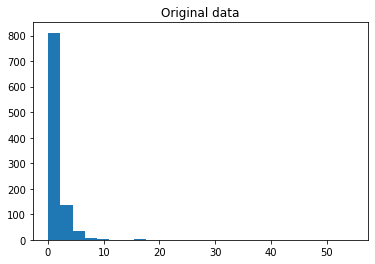

In [43]:
# demonstration of the quantile transform
from numpy import exp
from numpy.random import randn
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt

# generate gaussian data sample
data = randn(1000)

# add a skew to the data distribution
data = exp(data)

# histogram of the raw data with a skew
plt.hist(data, bins=25)
plt.title('Original data')
plt.show()

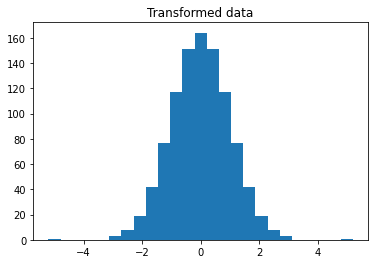

In [44]:
# reshape data to have rows and columns
data = data.reshape((len(data),1))

# quantile transform the raw data
quantile = QuantileTransformer(output_distribution='normal')
data_trans = quantile.fit_transform(data)

# histogram of the transformed data
plt.hist(data_trans, bins=25)
plt.title('Transformed data')
plt.show()

Quantile transformer always transform data into a Gaussian distribution. <br> 
However, if applied blindly to the whole dataset, it will distort the entire linear relationship <br>
Best practice is:  
1.   Split each class/feature out
2.   Apply QuantileTransformer
3.   Merge the data back

## *8.2. PowerTransformer*

**Usage**: it maps data from any distribution to as close to a Gaussian distribution as possible to stabilize variance and minimize skewness<br>
**Note**<br>
There are two types, Yeo-Johnson and Box-Cox:
*   *Yeo-Johnson*: works for all values, but too complex to explain to everyone.
*   *Box-Cox*: works for strictly positive data only, but easily explanable to everyone



In [45]:
X = np.random.RandomState(616).lognormal(size=(100, 3))
X[:5,:]

array([[1.28331718, 1.18092228, 0.84160269],
       [0.94293279, 1.60960836, 0.3879099 ],
       [1.35235668, 0.21715673, 1.09977091],
       [0.98751217, 3.10856524, 1.64193898],
       [0.88024529, 0.21202234, 4.17198777]])

Text(0.5, 1.0, 'Yeo-Johnson')

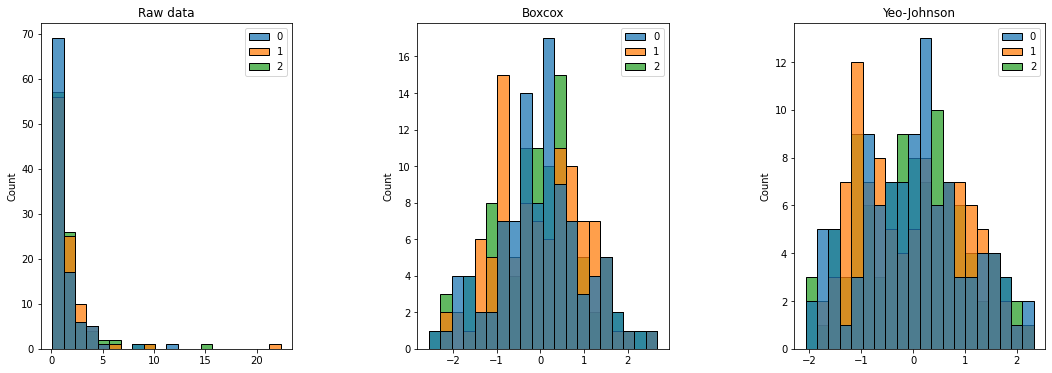

In [46]:
from sklearn.preprocessing import PowerTransformer
import seaborn as sns

# Define the settings for each subplot
f = plt.figure(figsize=(18,6))
f.subplots_adjust(wspace=.5, hspace=.5)

# Original data
ax = f.add_subplot(1,3,1)
sns.histplot(X, bins=20, color='r', ax=ax)
ax.set_title('Raw data')

# BoxCox transform
box_cox = PowerTransformer(method='box-cox', standardize=True)
data_boxcox = box_cox.fit_transform(X)

ax = f.add_subplot(1,3,2)
sns.histplot(data_boxcox, bins=20, color='g', ax=ax)
ax.set_title('Boxcox')

# Yeo-Johnson tranform
yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=True)
data_yeo_johnson = yeo_johnson.fit_transform(X)

ax = f.add_subplot(1,3,3)
sns.histplot(data_yeo_johnson, bins=20, color='b', ax=ax)
ax.set_title('Yeo-Johnson')

BoxCox tends to be slightly better.<br>
However, it doesn't work for 0 and negative values, unlike Yeo-Johnson.

# **9. Measure & Remove multicollinear**

Dataset: https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho

In [47]:
import pandas as pd
import numpy as np

In [48]:
df = pd.read_csv("./data/car data.csv")

df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [49]:
X = df.copy()
X.drop(columns=['Car_Name', 'Fuel_Type', 'Seller_Type', 'Transmission'], inplace=True, axis=1)

X.head()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
0,2014,3.35,5.59,27000,0
1,2013,4.75,9.54,43000,0
2,2017,7.25,9.85,6900,0
3,2011,2.85,4.15,5200,0
4,2014,4.60,6.87,42450,0


In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()

vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)

vif

,Features,VIF
1,Selling_Price,9.36
2,Present_Price,9.34
0,Year,2.78
3,Kms_Driven,2.22
4,Owner,1.07


As you can see, Selling_Price has VIF>5, indicating high collinearity. You should drop it and re-evaluate.

In [51]:
X = X.drop('Selling_Price', axis=1)

vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)

vif

,Features,VIF
0,Year,2.41
2,Kms_Driven,2.00
1,Present_Price,1.86
3,Owner,1.04


All features now have VIF<5. We have removed collinearity.